In [39]:
# This file is a simple implementation of the 
from keras.models import Sequential
from keras.layers import LSTM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
model = Sequential()
eurusd_train = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_train_normed.csv")
eurusd_test = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_test_normed.csv")
eurusd_train = eurusd_train.replace(np.nan, 0)
eurusd_test = eurusd_test.replace(np.nan, 0)

In [ ]:
from keras.models import Model # Dense
model.add(Dense(units=2, activation='relu', input_dim=2))
model.add(Dense(units=1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
x_train = np.array([[1,1],[1,0],[0,1],[0,0]])
y_train = np.array([0,1,0,0])
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=5, batch_size=32)

NameError: name 'Dense' is not defined

In [3]:
# set up the training data for the model
# we must normalise the inputs so they can pick up the correct values
data = [[[(i+j)/100]for i in range(0,5)] for j in range(0,200)]
target = [[(i+5)/100] for i in range(0,100)]
npData = np.array(data, dtype = float)
npTarget = np.array(target, dtype = float)
npData.shape
x_train, x_test, y_train, y_test = train_test_split(npData,npTarget,test_size = 0.2, random_state = 4)
# data stored as data[row_obversation][first_col_data][value_of_col]

ValueError: Found input variables with inconsistent numbers of samples: [200, 100]

In [41]:
# TODO Friday-> Tomorrow
# Get LSTM model working with your train,test data first
# get it learning and giving output. Then look to refine the model. think about the target, how will we create probability distributions? 
# get the EURUSD data
# Chose the trainign size of the data
DATA_SIZE = 1500
#npData.shape
train_original = eurusd_train.iloc[-DATA_SIZE:,:]
test_original = eurusd_test.iloc[:DATA_SIZE,:]
features_to_use = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff", "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]
# Data needs to be reshaped into 3D tensor
train_sample = eurusd_train[features_to_use].iloc[-DATA_SIZE:,:].values
test_sample = eurusd_test[features_to_use].iloc[:DATA_SIZE,:].values
#sample_data['target'] = 1
#target.shape
# this creates your dataset with the lookback periods it needs to use.

import numpy as np
# this lookbacks over a set period as the memory for the LSTM
look_back = 30
def create_dataset(dataset, populate_target ,look_back=look_back):
  dataX, dataY, target_dates = [], [], []
  for i in range(len(dataset)-look_back+1):
      # this takes the very last col as the target
    a = dataset[i:(i+look_back), :-1]
    dataX.append(a)
    # this code assumes that the target vector is the very last col.
    dataY.append(dataset[i + look_back - 1, -1])
    if populate_target:
        target_dates.append(test_original['Date'].loc[i + look_back - 1])
  return np.array(dataX), np.array(dataY), target_dates

train_sample_transformed = create_dataset(train_sample,False, look_back)
train_data = train_sample_transformed[0]
train_target = train_sample_transformed[1]

test_sample_transformed = create_dataset(test_sample, True, look_back)
test_data = test_sample_transformed[0]
test_target = test_sample_transformed[1]
target_dates = test_sample_transformed[2]

# reshape sems to add another list around every observation
train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], 1)

test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
test_target = test_target.reshape(test_target.shape[0], 1)


In [12]:
#
#print(eurusd_train.iloc[-200:,:])
#from matplotlib import pyplot as plt
x = eurusd_train.iloc[-DATA_SIZE:,-1:].reset_index(drop = True)
y = eurusd_test.iloc[:DATA_SIZE,:].reset_index(drop = True)
#x.iloc[:,0].plot()
#y.iloc[:,0].plot()
#print(x.head(60))
#print(train_target)
print(len(target_dates))


1471


In [102]:
#rough work
"""
dataset = eurusd.iloc[:100,:].values
i = 0
look_back = 5
dataX, dataY = [], []
a = dataset[i:(i+look_back), :]
#dataX.append(a)
dataY.append(dataset[i + look_back - 1, -1])
dataY
"""

'\ndataset = eurusd.iloc[:100,:].values\ni = 0\nlook_back = 5\ndataX, dataY = [], []\na = dataset[i:(i+look_back), :]\n#dataX.append(a)\ndataY.append(dataset[i + look_back - 1, -1])\ndataY\n'

In [193]:
#sample_data = sample_data.reshape(sample_data.shape[0], sample_data.shape[1], sample_data.shape[3])
#sample_data[0]

In [59]:
# this code sets up the LSTM model.
'''
Original
model = Sequential()
model.add(LSTM((1),batch_input_shape = (None,5,1), return_sequences = True))
model.add(LSTM((1), return_sequences = False))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()
'''
# need to try understand the input shapes and what is required of it.
# look at tutorials where they use this data
# Friday:GOAL have the LSTM working with your input (and variable data set)
# BONUS GOAL: simulate trendy and mean reverty data.
# batch_input_shape (no_obversations,timelookback, features)
# set batch size (this is how often the weights will update
BATCH_SIZE = 300
no_features = train_data.shape[2]
model = Sequential()
model.add(LSTM(8,batch_input_shape = (None,look_back,no_features), return_sequences = True))
model.add(LSTM(1, return_sequences = False))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 8)             576       
_________________________________________________________________
lstm_8 (LSTM)                (None, 1)                 40        
Total params: 616
Trainable params: 616
Non-trainable params: 0
_________________________________________________________________


In [60]:
# model training
'''
history = model.fit(x_train,y_train, epochs=100,validation_data=(x_test,y_test))
results = model.predict(x_test)
'''
history = model.fit(train_data,train_target,epochs = 1000,validation_data=(test_data,test_target), verbose=0)

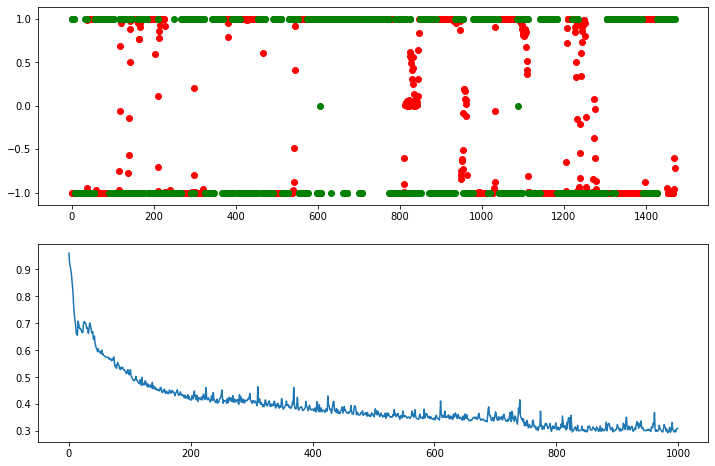

In [61]:
# plot results
import matplotlib.pyplot as plt
results = model.predict(test_data)
fig , ax = plt.subplots(2,1,figsize=(12,8))
ax[0].scatter(range(len(results)), results, c = "r")
ax[0].scatter(range(len(test_target)), test_target, c = "g")
# lets see the history of the error update.
ax[1].plot(history.history['loss'])
plt.show()

In [19]:
features_to_use = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",	"MF_ema_diff","LF_ema_diff"]
train_sample = eurusd_train[features_to_use].iloc[-DATA_SIZE:,:].values
#test_sample = eurusd_test.iloc[:200,features_to_use].values

array([[-3.77077251, -3.62112174, -2.03388392, -4.85746873, -2.01641818,
         0.33070086],
       [-4.09020146, -3.69558669, -2.07626712, -4.83655507, -2.02458851,
         0.32852463],
       [-4.60197656, -3.81557922, -2.1431084 , -4.86914407, -2.03328911,
         0.32627671],
       ...,
       [-0.80929306,  0.09202221, -0.31229262, -0.47708991, -0.71461784,
        -1.06383853],
       [-0.75726148,  0.09778996, -0.30904073, -0.46443473, -0.71445716,
        -1.06284846],
       [-0.68397369,  0.10862184, -0.30307008, -0.4479426 , -0.71424005,
        -1.06185307]])

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

predicted = [np.sign(i[0]) for i in results]
true_class = [np.sign(i[0]) for i in test_target]
print(accuracy_score(true_class, predicted))

print(pd.DataFrame(
    confusion_matrix(true_class, predicted),
    columns=['Predicted Buy',"shithouse",'Predicted Sell'],
    index=['True Buy',"shithouse",'True Sell']
))
# To do --> Create a relatively realistic backtester (probably needs to be a .py file engine)
# Run the model on the real data (explore running on a server. tie a small subset of data to see how long it might actually take?
# test model on test data and see if returns work.
# create a timeseries that generates a trendy or non trendy price series on same frequency as the hourly eurusd data.
# test the model to see if it can pick this up. 
# potential GM questions, LSTM architecture? Best practises around standardisation? Are you implementing the notes and points reaised by the
# examiners?
# Ultimate GOAL: create a trend baseded model which can actually pick up price action and place bet sizes which are relatively intelligent.
# is there a way of testign some neuro fuzzy logic perhaps?
# Probabitily distribution of outcomes for each trade based on the trend and external factors

0.4663494221617947
           Predicted Buy  shithouse  Predicted Sell
True Buy             320          4             423
shithouse              0          0               2
True Sell            356          0             366


In [21]:
single_sample = np.array([test_data[0]])
#print(model.predict(single_sample))
#print(results)
#print(eurusd_test.iloc[:200,:].head())
test_original['Predictions'].shift(2)

KeyError: 'Predictions'

In [50]:
#backtester_type_code
#test_original['predicted'] = results
predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
test_original = pd.merge(test_original,predictions,how="left", on="Date").fillna(0)
test_original['strat_returns'] = test_original['logret']*test_original['Predictions'].shift(2)
test_original['strat_returns_sum'] = test_original['strat_returns'].cumsum()
test_original.columns

Index(['spot_v_HF', 'spot_v_MF', 'spot_v_LF', 'HF_ema_diff', 'MF_ema_diff',
       'LF_ema_diff', 'Date', 'CCY', 'logret', 'LDN', 'NY', 'Asia',
       'target_raw', 'target', 'Predictions_x', 'strat_returns',
       'strat_returns_sum', 'Predictions_y', 'Predictions'],
      dtype='object')

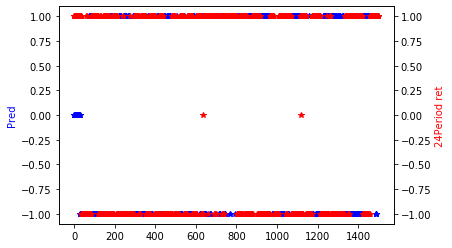

In [63]:
#print(test_original[['Date',"CCY","Predictions", "logret", "strat_returns"]].head(50)) # "strat_returns_sum", "logret"
# plotting the results
ax1 = plt.plot()
s1 = test_original['Predictions']
plt.plot(s1,'b*')
plt.ylabel('Pred',color='b')

ax2 = plt.gca().twinx()
s2 = test_original['target']
ax2.plot(s2, 'r*')
plt.ylabel('24Period ret', color='r')
plt.show()

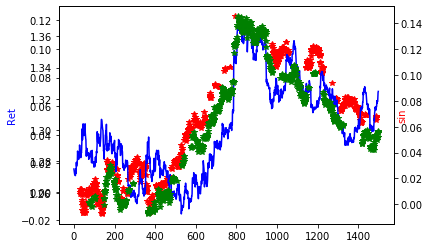

In [71]:
# plotting the results

ax1 = plt.plot()
s1 = test_original['strat_returns_sum'].loc[test_original['Predictions_x'] <0]
plt.plot(s1,'r*')
plt.ylabel('Ret',color='b')

ax2 = plt.gca().twinx()
s2 = test_original['CCY']
ax2.plot(s2, 'b')
plt.ylabel('sin', color='r')
ax2 = plt.gca().twinx()
s3 = test_original['strat_returns_sum'].loc[test_original['Predictions_x'] >0]
ax2.plot(s3, 'g*')
plt.show()